# Code from ER class

In [1]:
import scipy as sp
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx

Let's compare the memory usage between a sparse and a normal matrix.
Moreover, we assume a microcanonical ensemble, fixing the number of nodes and links.

In [2]:
Nnode = int(1e3)
Nlink = int(3e4)
Net1 = sp.sparse.lil_matrix((Nnode,Nnode))
Net2 = np.zeros((Nnode,Nnode))

print(sys.getsizeof(Net1))
print(sys.getsizeof(Net2))

48
8000128


## Microcanonical ensemble

Now, let's try to generate a random graph without using Networkx functions.

In [3]:
for index in range(100):
    # generate a random link
    ii = np.random.randint(Nnode, size=(Nlink, 2))
    # create a sparse matrix using these links
    NetM = sp.sparse.coo_matrix((np.ones(Nlink), (ii[:,0], ii[:,1])), shape=(Nnode, Nnode))
    #remove loops
    NetM.setdiag(0)
    # symmetrize
    NetM = NetM + NetM.T
print(NetM)

  (0, 11)	1.0
  (0, 103)	1.0
  (0, 132)	1.0
  (0, 143)	1.0
  (0, 161)	1.0
  (0, 222)	1.0
  (0, 229)	1.0
  (0, 231)	1.0
  (0, 260)	1.0
  (0, 317)	2.0
  (0, 338)	1.0
  (0, 339)	1.0
  (0, 340)	1.0
  (0, 357)	1.0
  (0, 418)	1.0
  (0, 465)	1.0
  (0, 481)	1.0
  (0, 532)	1.0
  (0, 539)	1.0
  (0, 585)	1.0
  (0, 593)	1.0
  (0, 600)	1.0
  (0, 605)	1.0
  (0, 622)	1.0
  (0, 627)	1.0
  :	:
  (999, 551)	1.0
  (999, 567)	1.0
  (999, 575)	1.0
  (999, 621)	1.0
  (999, 625)	1.0
  (999, 667)	1.0
  (999, 715)	1.0
  (999, 716)	1.0
  (999, 719)	1.0
  (999, 721)	1.0
  (999, 750)	1.0
  (999, 754)	1.0
  (999, 795)	1.0
  (999, 802)	1.0
  (999, 821)	1.0
  (999, 844)	1.0
  (999, 849)	1.0
  (999, 855)	1.0
  (999, 866)	1.0
  (999, 871)	1.0
  (999, 877)	1.0
  (999, 882)	1.0
  (999, 986)	1.0
  (999, 987)	1.0
  (999, 995)	1.0


**NOTE** that reciprocal links and repeated links randomly created reduce symmetric links with a probability that scales as $\frac{1}{{Nnode}^2}$

Let's count the number of links in the matrix.

In [4]:
Nl = int(NetM.count_nonzero()/2)
print('Randomly generated links: {:d}'.format(Nl))
print('Missing links for microcanonical ensemble: {:d}'.format(Nlink-Nl))

Randomly generated links: 29039
Missing links for microcanonical ensemble: 961


We notice that we miss some links, then we add one by one missing links until microcanonical constraint fulfilled.

In [5]:
while Nl < Nlink:
    i1 = np.random.randint(Nnode)
    i2 = np.random.randint(Nnode)
    if i1 != i2 and NetM[i1,i2] == 0:
        NetM[i1,i2] = 1
        NetM[i2,i1] = 1 # symmetric link
        Nl += 1

/home/grufoony/.local/lib/python3.10/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Lastly, let's compute the degree vector, finding minimum and maximum.

In [6]:
K = sum(NetM)
print('Average degree: {:.2f}'.format(np.mean(K)))
print('Minimum degree: {:d}'.format(int(np.min(K))))
print('Maximum degree: {:d}'.format(int(np.max(K))))

Average degree: 61.84
Minimum degree: 40
Maximum degree: 89


## Canonical ensemble

Let's now try to build a canonical ensemble.

In [7]:
Nnode = int(1e2)
Plink = 0.3
Nexp = int(1e4)

In [8]:
LinkS = np.zeros((Nexp, 1))
for index in range(Nexp):
    NetC = sp.sparse.triu(sp.sparse.rand(Nnode, Nnode, density=Plink, format='csr'), k=1)
    NetC = NetC + NetC.T
    LinkS[index] = NetC.count_nonzero()/2

Let's see some stats

Average number of links: 1484.78
Standard deviation: 22.99
Expected number of links: 1485.00
Expected standard deviation: 32.24


<Axes: ylabel='Count'>

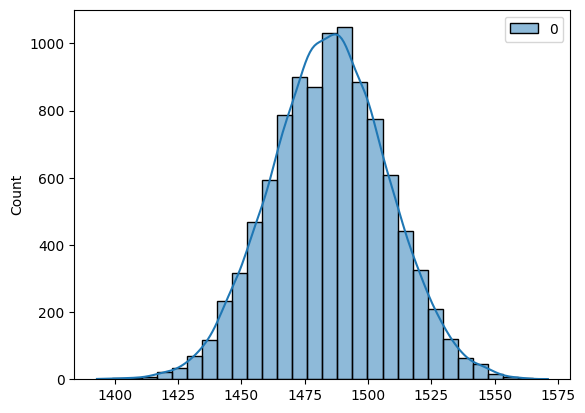

In [9]:
print('Average number of links: {:.2f}'.format(np.mean(LinkS)))
print('Standard deviation: {:.2f}'.format(np.std(LinkS)))

print('Expected number of links: {:.2f}'.format(Plink*Nnode*(Nnode-1)/2))
print('Expected standard deviation: {:.2f}'.format(np.sqrt(Plink*(1-Plink)*Nnode*(Nnode-1)/2)))

sns.histplot(data=LinkS, bins=30, kde=True)

The degree distribution for increasing size - CV decreases.
Tends to the delta function - regular graph.

In [10]:
Pow = 4.21 # max network size
Pl = 0.1
Cnt = 0

M = []
S = []
CV = []
Nnodes = []

In [11]:
for index in np.arange(2, Pow, step=0.3):
    Nnodes.append(int(10**index))
    NetC = sp.sparse.triu(sp.sparse.rand(Nnodes[Cnt], Nnodes[Cnt], density=Pl, format='csr'), k=1)
    NetC = NetC + NetC.T
    K = sum(NetC).todense()
    M.append(np.mean(K))
    S.append(np.std(K))
    CV.append(np.std(K)/np.mean(K))
    # sns.histplot(data=K, bins=30, kde=True, label='N={:d}'.format(Nnodes[Cnt]))
    print('N={:d} - Average degree: {:.2f}'.format(Nnodes[Cnt], M[Cnt]))
    print('N={:d} - Standard deviation: {:.2f}'.format(Nnodes[Cnt], S[Cnt]))
    print('N={:d} - CV: {:.2f}'.format(Nnodes[Cnt], CV[Cnt]))
    Cnt += 1

N=100 - Average degree: 4.81
N=100 - Standard deviation: 1.73
N=100 - CV: 0.36
N=199 - Average degree: 9.86
N=199 - Standard deviation: 2.63
N=199 - CV: 0.27
N=398 - Average degree: 19.87
N=398 - Standard deviation: 3.43
N=398 - CV: 0.17
N=794 - Average degree: 39.64
N=794 - Standard deviation: 4.82
N=794 - CV: 0.12
N=1584 - Average degree: 79.16
N=1584 - Standard deviation: 6.86
N=1584 - CV: 0.09
N=3162 - Average degree: 157.66
N=3162 - Standard deviation: 9.91
N=3162 - CV: 0.06
N=6309 - Average degree: 315.27
N=6309 - Standard deviation: 13.65
N=6309 - CV: 0.04
N=12589 - Average degree: 629.47
N=12589 - Standard deviation: 19.61
N=12589 - CV: 0.03


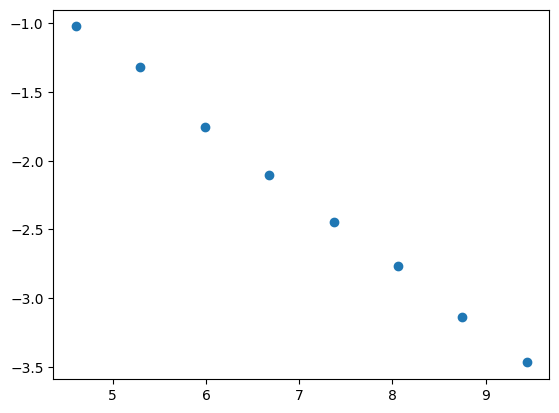

In [12]:
plt.scatter(np.log(Nnodes), np.log(CV), label='Mean')

## Giant component transition

In [13]:
Nnode = int(1e2)

rr = np.triu(np.random.rand(Nnode, Nnode), k=1)
rr = rr + rr.T

In [14]:
Pmin = 1 / (20 * Nnode)
Pmax = 6 / Nnode
xP = np.arange(Pmin, Pmax, step=0.00002)

**NOTE** that $\lambda = xP * Nnode$

In [15]:
Rc = np.zeros(len(xP))
Rm = np.zeros(len(xP))
Cnt = 0



for index in xP:
    Net = nx.from_numpy_array(rr > 1 - index)
    CompList = nx.connected_components(Net)
    Comps = [len(x) for x in CompList]
    Rc[Cnt] = max(Comps)
    Rm[Cnt] = np.mean(Comps)
    Cnt += 1

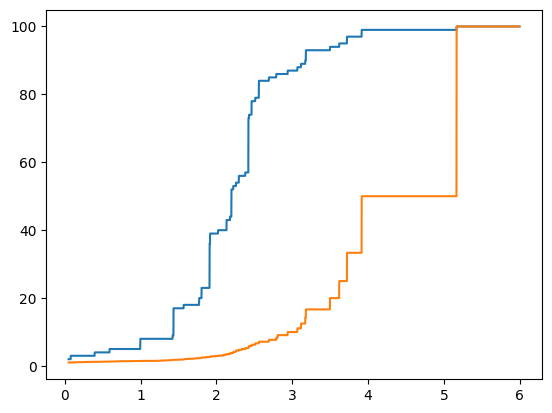

In [16]:
plt.plot(xP*Nnode, Rc)
plt.plot(xP*Nnode, Rm)